## Background

The Quantum Approximate Optimization Algorithm (QAOA) is a hybrid iterative method for solving combinatorial optimization problems.  You can learn more about this algorithm [here](https://learn.qiskit.org/course/ch-applications/solving-combinatorial-optimization-problems-using-qaoa).  In this tutorial we demonstrate how to implement the QAOA algorithm using Qiskit Runtime for solving a simple max-cut problem.


In a max-cut problem, we want to partition nodes of a graph in a way that maximizes the number of edges between nodes in differing groups. The desired max-cut partition for the graph below is clear: the 0th-node on the left should be separated from the rest of the nodes on the right by a cut. We will find this answer by applying QAOA by using Qiskit Runtime primitives and sessions. 

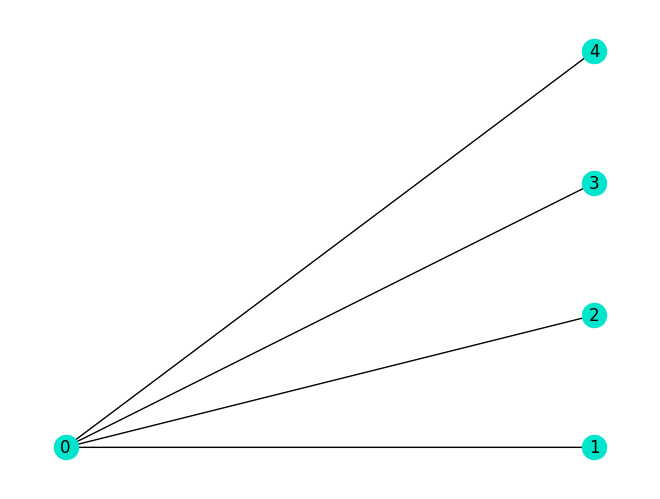

In [1]:
import rustworkx as rx
from rustworkx.visualization import mpl_draw

num_nodes = 5
# The edge syntax is (start, end, weight)
edges = [(0, 1, 1), (0, 2, 1), (0, 3, 1), (0, 4, 1)]

G = rx.PyGraph()
G.add_nodes_from(range(num_nodes))
G.add_edges_from(edges)
mpl_draw(G, pos=rx.bipartite_layout(G, {0}), with_labels=True, node_color="#00e5cc")

## Setup

In [2]:
# General imports
import numpy as np

# Pre-defined ansatz circuit, operator class and visualization tools
from qiskit.circuit.library import QAOAAnsatz
from qiskit.quantum_info import SparsePauliOp
from qiskit.visualization import plot_distribution

# IBM Qiskit Runtime
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime import Estimator, Sampler, Session

# SciPy minimizer routine
from scipy.optimize import minimize

## Initialize Runtime service and select backend

First, we need to instantiate the IBM Quantum Runtime service `QiskitRuntimeService` in order to choose a [computational resource](https://quantum-computing.ibm.com/services/resources?tab=systems&limit=40) on which to execute our QAOA algorithm. In this tutorial, the `ibmq_qasm_simlator` is chosen.

In [6]:
service = QiskitRuntimeService(channel='ibm_quantum')

# Select your simulator
backend = service.least_busy(simulator=True, operational=True)
backend.name

'ibmq_qasm_simulator'

## QAOA Hamiltonian and ansatz

To utilize QAOA algorithm for a max-cut problem we require a Pauli Hamiltonian that encodes the cost in a manner such that the minimum expectation value of the operator corresponds to the maximum number of edges between the nodes in two different groups.  

For this simple example, the operator is a linear combination of terms with `Z` operators on nodes connected by an edge (recall that the 0th qubit is farthest right): $IIIZZ + IIZIZ + IZIIZ + ZIIIZ$. Once the operator is constructed, the ansatz for the QAOA algorithm can easily be built by using the `QAOAAnsatz` circuit from the Qiskit circuit library.

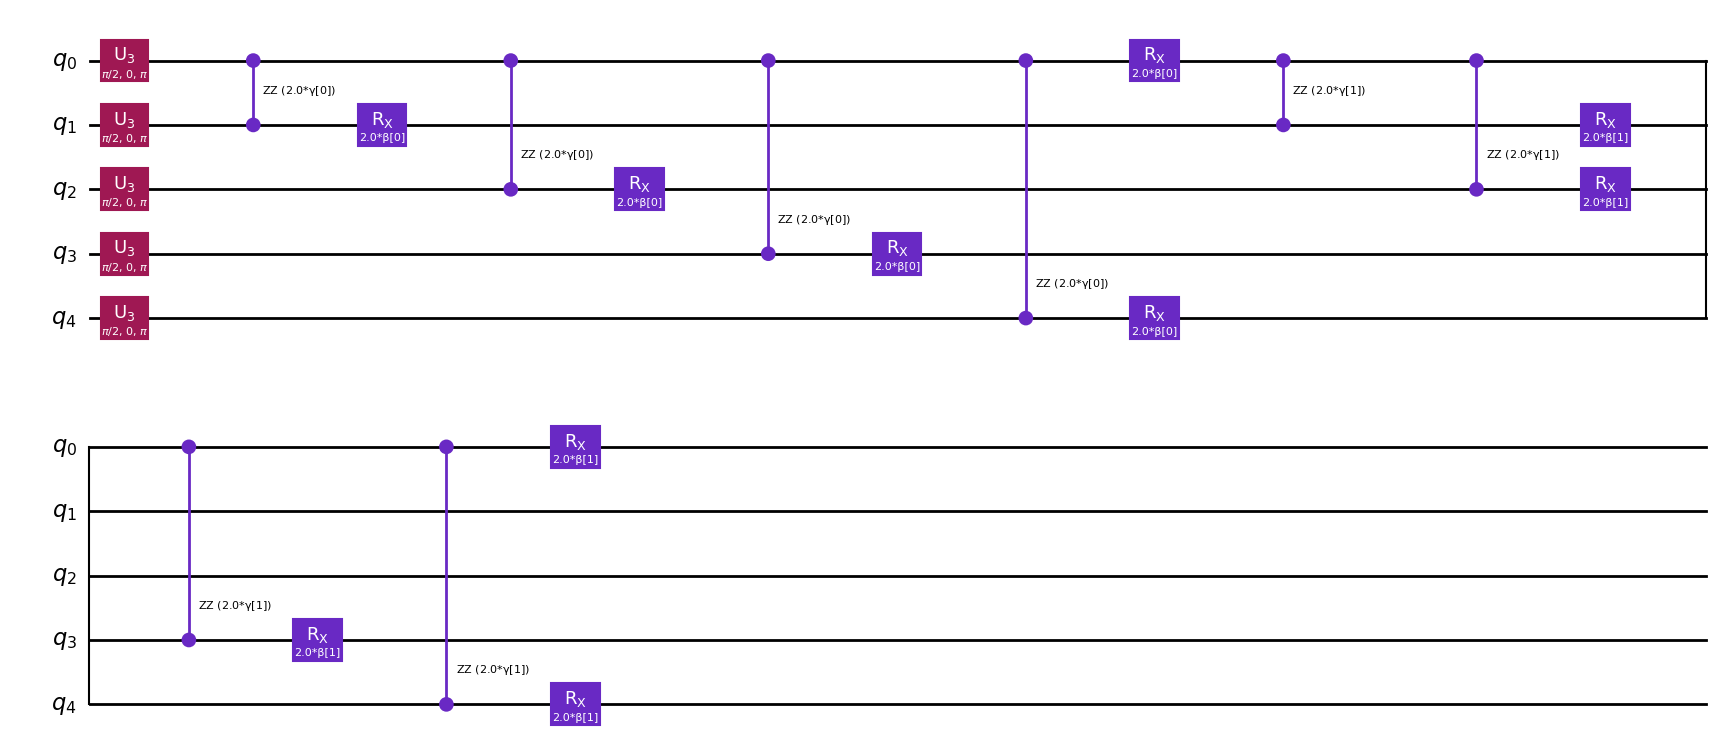

In [7]:
# Problem to Hamiltonian operator
hamiltonian = SparsePauliOp.from_list([("IIIZZ", 1), ("IIZIZ", 1), ("IZIIZ", 1), ("ZIIIZ", 1)])
# QAOA ansatz circuit
ansatz = QAOAAnsatz(hamiltonian, reps=2)
# Draw
ansatz.decompose(reps=3).draw("mpl")

The previous image illustrates the ansatz in basic gates for clarity. However, it can be expressed in multiple levels of decomposition by changing the `reps` argument or by drawing the circuit without the `decompose` method. For example, the following representation directly shows the QAOA structure with the default `reps` value, which is `reps=1`. 

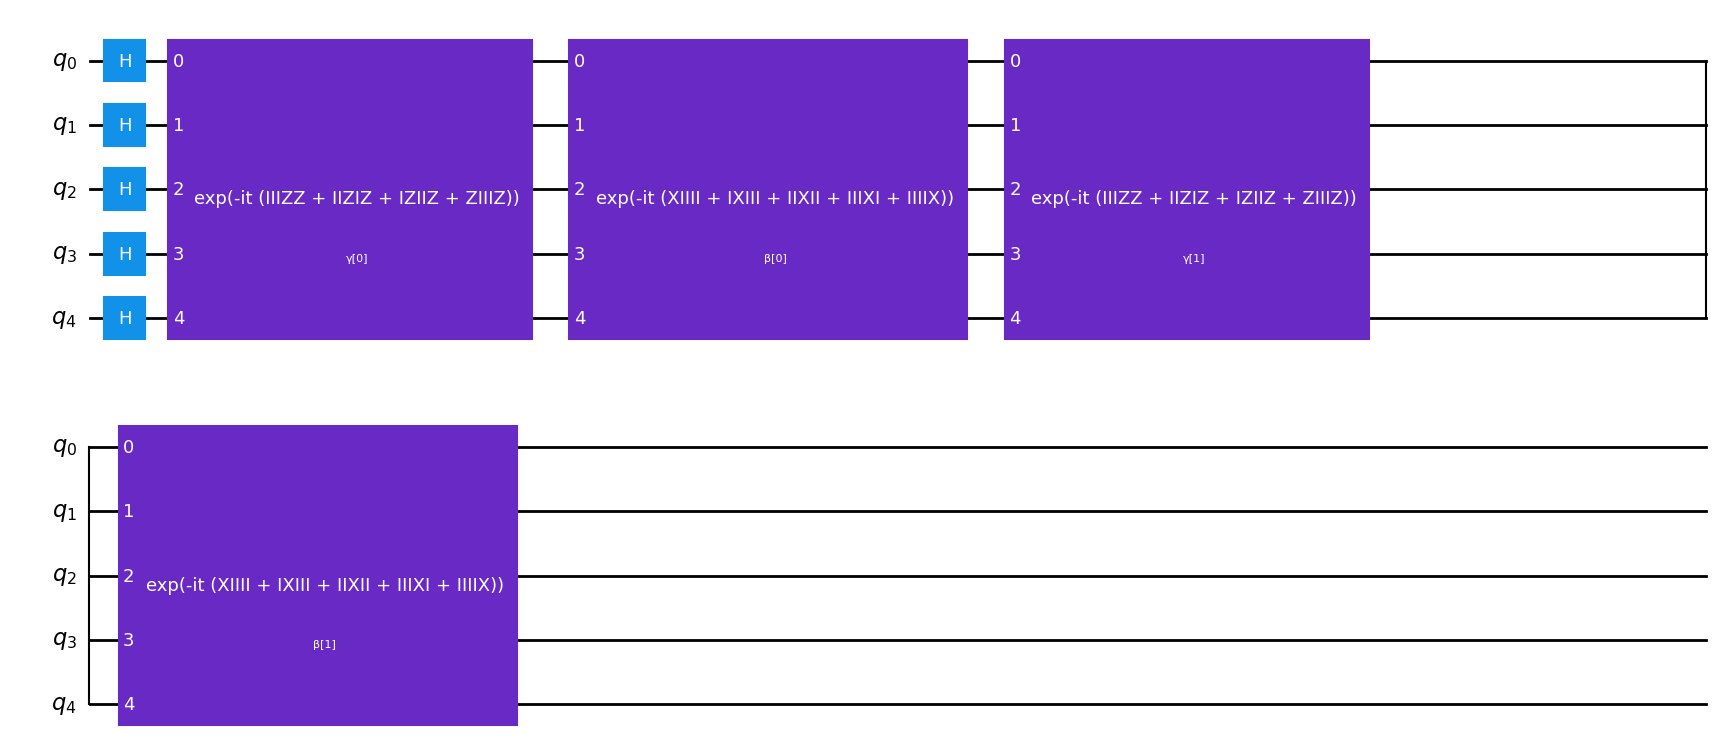

In [8]:
ansatz.decompose().draw("mpl")

## Define the cost function by using Estimator

As with an iterative optimization procedure, we now need to define our cost function over which to minimize.  We proceed in an identical manner to the [VQE tutorial](vqe_with_estimator.ipynb), computing the expectation value of our Hamiltonian with respect to the parameterized ansatz circuit using the Qiskit Runtime `Estimator` primitive:

In [9]:
def cost_func(params, ansatz, hamiltonian, estimator):
    """Return estimate of energy from estimator

    Parameters:
        params (ndarray): Array of ansatz parameters
        ansatz (QuantumCircuit): Parameterized ansatz circuit
        hamiltonian (SparsePauliOp): Operator representation of Hamiltonian
        estimator (Estimator): Estimator primitive instance

    Returns:
        float: Energy estimate
    """
    cost = estimator.run(ansatz, hamiltonian, parameter_values=params).result().values[0]
    return cost

## Minimize the cost function

Any classical optimizer can be used to minimize the cost function.  On a real quantum system, an optimizer designed for non-smooth cost function landscapes usually does better.  Here we use the [COBYLA routine from SciPy via the minimize function](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html).

Because we are iteratively executing many calls to Runtime, we make use of a `Session` in order to execute all calls within a single block.  Moreover, for QAOA, the solution is encoded in the output distribution of the ansatz circuit bound with the optimal parameters from the minimization.  Therefore, we will need a `Sampler` primitive as well, and will instantiate it with the same `Session`.

In [77]:
session = Session(backend=backend)

estimator = Estimator(session=session, options={"shots": int(1e4)})
sampler = Sampler(session=session, options={"shots": int(1e4)})

We now set an initial set of random parameters:

In [66]:
x0 = 2 * np.pi * np.random.rand(ansatz.num_parameters)

and run our minimization routine:

In [67]:
res = minimize(cost_func, x0, args=(ansatz, hamiltonian, estimator), method="COBYLA")

In the end, we have a result in the standard SciPy `OptimizeResult` format.

In [68]:
res

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -3.1462000000000003
       x: [ 2.072e+00  1.878e+00  5.420e+00  3.549e+00]
    nfev: 68
   maxcv: 0.0

## Solution to max-cut

The solution vector of parameter angles (`x`), when plugged into the `ansatz` circuit, yields the graph partitioning that we were looking for.

In [73]:
# Assign solution parameters to ansatz
qc = ansatz.assign_parameters(res.x)
# Add measurements to our circuit
qc.measure_all()

In [78]:
# Sample ansatz at optimal parameters
samp_dist = sampler.run(qc, shots=int(1e4)).result().quasi_dists[0]
# Close the session since we are now done with it
session.close()

For small problem instances, the solution can be visually obtained:

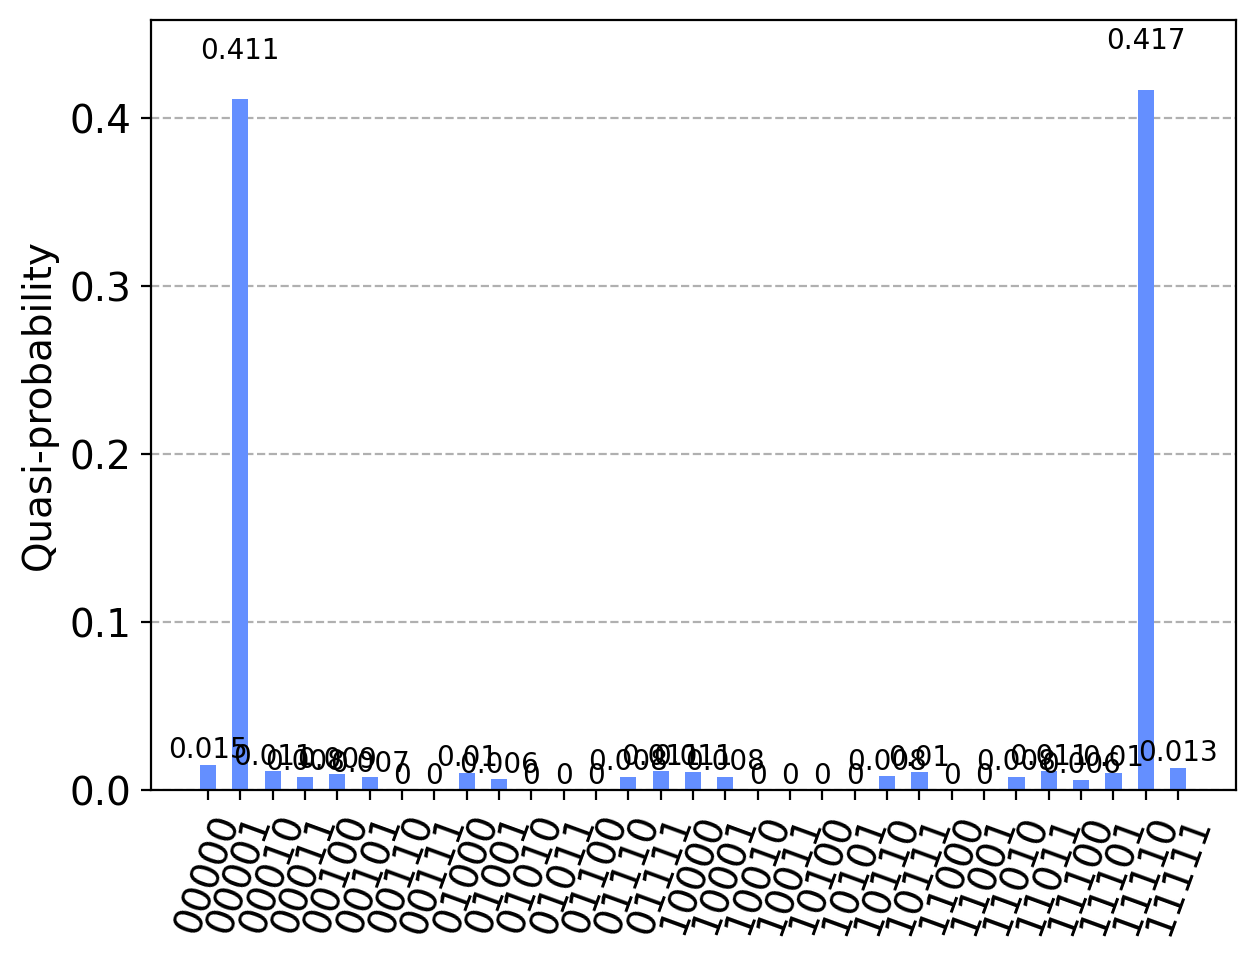

In [80]:
plot_distribution(samp_dist.binary_probabilities())

In [ ]:
# Close session
session.close()

The most probable bit-strings, up to finite-sampling deviations, encode the solution.  Here we see that `00001` and `11110` are found, and are indeed correct.  There are two solutions because the labeling of the two partitions with `'0'` or `'1'` is arbitrary.

In [10]:
import qiskit_ibm_runtime

qiskit_ibm_runtime.version.get_version_info()

'0.11.3'

In [11]:
import qiskit

qiskit.version.get_version_info()

'0.25.0'